In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import sys
import math

from sklearn import preprocessing, cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import matplotlib

from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic

from sklearn import metrics
import itertools
from itertools import product

from mpl_toolkits.basemap import Basemap

In [16]:
radius = 10000                         #Choose your own radius
radiusInDegrees=radius/111300            
r = radiusInDegrees
x0 = 18.5204
y0 = 73.8567

latitude=[]
longitude=[]
coordinates=[]
for i in range(1,50):                 #Choose number of Lat Long to be generated
    
    u = float(random.uniform(0.0,1.0))
    v = float(random.uniform(0.0,1.0))

    w = r * math.sqrt(u)
    t = 2 * math.pi * v
    x = w * math.cos(t) 
    y = w * math.sin(t)
  
    xLat  = x + x0
    yLong = y + y0
    
    latitude.append(xLat)
    longitude.append(yLong)
    

coordinates = list(zip(latitude,longitude))

data = pd.DataFrame(coordinates, columns=['latitude','longitude'])

data.head()

,latitude,longitude
0,18.498073,73.833969
1,18.545200,73.839160
2,18.491661,73.863419
3,18.482785,73.788478
4,18.512250,73.820965


In [17]:
def getClusterSize(df):
    
    X = df[["latitude","longitude"]]

    max_k = 10

    ## iterations
    distortions = [] 
    
    for i in range(1, max_k+1):
        if len(X) >= i:
            model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(X)
            distortions.append(model.inertia_)

    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

    return k, distortions

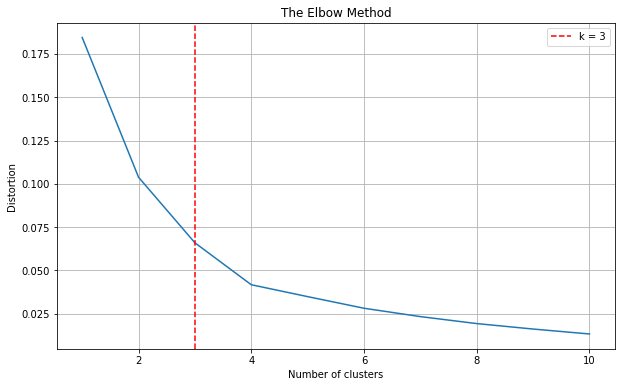

In [18]:
clust_size, distortions = getClusterSize(data)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(clust_size, ls='--', color="red", label="k = "+str(clust_size))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [19]:
df_kmeans = data.copy()

model = KMeans(n_clusters=clust_size, init='k-means++', max_iter=300, n_init=10, random_state=0)

X = df_kmeans[["latitude","longitude"]]

model.fit_predict(X)

df_kmeans['cluster'] = model.labels_


Text(0, 0.5, 'Latitude')

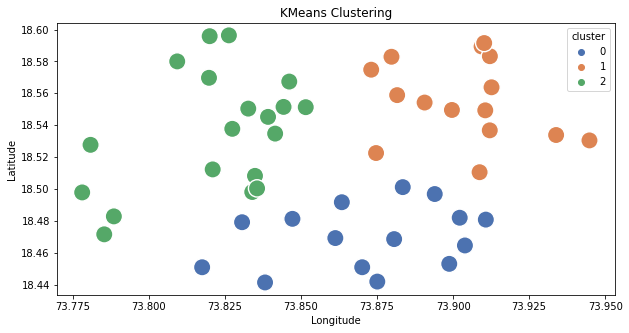

In [20]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x="longitude", y="latitude", data=df_kmeans, 
                hue='cluster', palette="deep", s=300, 
                legend="brief", ax=ax)
ax.set_title('KMeans Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [21]:
df_kmeans['cluster'].value_counts()

2    19
0    15
1    15
Name: cluster, dtype: int64

In [22]:
df  = data.copy()
coords = df[['latitude', 'longitude']].values

In [23]:
def distance_in_meters(x, y):
    #print(x[0], x[1],y[0], y[1])
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    
    return geodesic((lat1, lon1), (lat2, lon2)).km

distance_matrix = pairwise_distances(coords, metric=distance_in_meters)

In [24]:
distance_matrix[5].mean()

10.132853813716636

In [25]:
eps = np.arange(1.2,2,0.1)   # unit: meter
min_sample = np.arange(2,4)
dbscan_params = list(product(np.around(eps,2),min_sample))

clusters = []
noise = []
sil_score = []
epsvalues = []
min_samp = []

np.random.seed(42)

try:
    
    for p in dbscan_params:

        dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1], metric='precomputed', n_jobs=-1).fit(distance_matrix)
        #dbscan_cluster_labels = dbscan_cluster.fit_predict(distance_matrix)

        epsvalues.append(p[0])
        min_samp.append(p[1])
        clusters.append(len(np.unique(dbscan_cluster.labels_)))
        noise.append(list(dbscan_cluster.labels_).count(-1))
        sil_score.append(metrics.silhouette_score(df, dbscan_cluster.labels_))
except Exception:
    pass
    
eps_min = list(zip(clusters,noise,sil_score, epsvalues, min_samp))

df_eps_min = pd.DataFrame(eps_min, columns=['clusters', 'noise', 'silhouette_score', 'epsilon_values', 'minimum_points'])

df_eps_min.sort_values(by=['silhouette_score']).tail(5)



,clusters,noise,silhouette_score,epsilon_values,minimum_points
6,13,16,0.217235,1.5,2
8,14,13,0.278641,1.6,2
10,14,12,0.299449,1.7,2
14,14,9,0.322835,1.9,2
12,15,9,0.331946,1.8,2


In [26]:
epsilon = 2.0 #/ kms_per_radian

np.random.seed(42)
db = DBSCAN(eps=epsilon, min_samples=2, metric='precomputed', n_jobs=-1,)

cluster_labels = db.fit_predict(distance_matrix)
df['cluster'] = db.labels_


num_clusters = len(set(cluster_labels))


n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, cluster_labels))


Estimated number of clusters: 11
Estimated number of noise points: 8
Silhouette Coefficient: 0.974


Text(0, 0.5, 'Latitude')

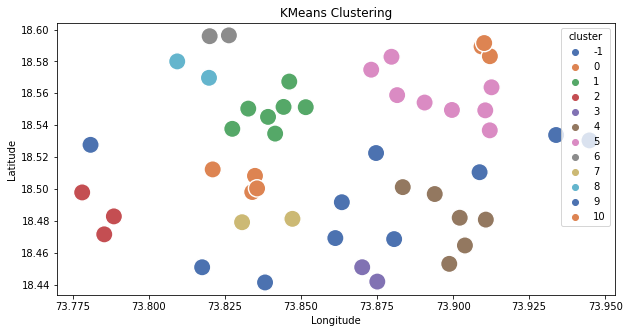

In [27]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x="longitude", y="latitude", data=df, 
                hue='cluster', palette="deep", s=300, 
                legend="brief", ax=ax)
ax.set_title('KMeans Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support <AxesSubplot:title={'center':'Full data set vs DBSCAN reduced set'}, xlabel='Longitude', ylabel='Latitude'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


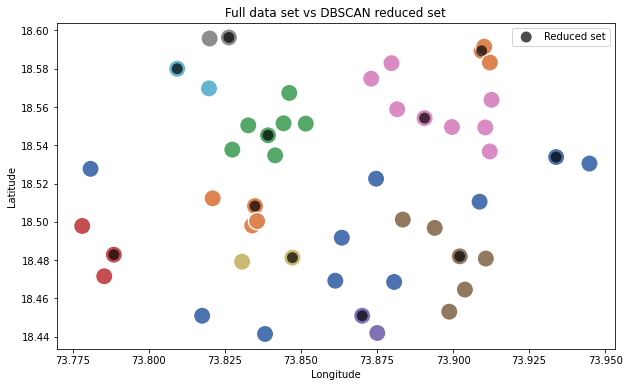

In [28]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)


clusters = pd.Series([coords[db.labels_ == n] for n in range(n_clusters_)])
centermost_points = clusters.map(get_centermost_point)
#centermost_points

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
#rep_points

rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat']) & (df['longitude']==row['lon'])].iloc[0], axis=1)
#rs

fig, ax = plt.subplots(figsize=[10, 6])

sns.scatterplot(x="longitude", y="latitude", data=df, 
                hue='cluster', palette="deep", s=300, 
                legend="brief", ax=ax)

rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='black', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax

ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [31]:
import folium

X = data[["latitude", "longitude"]]

lat = list(data['latitude'])
lon = list(data['longitude'])
margin = 0.01 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin


map = folium.Map(location=[data.latitude.mean(), data.longitude.mean()], width='80%', height='80%',
                 min_lat=lat_min, max_lat=lat_max, min_lon=lon_min, max_lon=lon_max,
                 zoom_start=15, control_scale=True)
                 
for index, location_info in data.iterrows():
                 folium.Marker([location_info["latitude"], location_info["longitude"]], popup=index).add_to(map)

In [32]:
map